In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.losses import mse

2023-10-09 10:58:53.323393: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 10:58:53.351295: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 10:58:53.352220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 10:58:53.984119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
n_el = 16
r_obj = 0.4
dist_exc = 8
step_meas = 4

load_path = f"data/{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

This directory exists...continue


In [3]:
V = np.load("saves/" + load_path.split("/")[1] + "_v_data.npy", allow_pickle=True)

In [4]:
V.shape

(249, 192)

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = keras.backend.random_normal(
        shape=(keras.backend.shape(z_mean)[0], latent_dim)
    )
    return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

In [6]:
latent_dim = 4

encoder_inputs = keras.Input(shape=(192,))

x = layers.Dense(64, activation="relu")(encoder_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)


z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   12352     ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 32)                   2080      ['dense[0][0]']               
                                                                                                  
 flatten (Flatten)           (None, 32)                   0         ['dense_1[0][0]']             
                                                                                            

2023-10-09 10:58:55.086449: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [7]:
# Definiere den Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(192, activation="relu")(x)
decoder_outputs = layers.Flatten()(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 16)                80        
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dense_6 (Dense)             (None, 192)               12480     
                                                                 
 flatten_1 (Flatten)         (None, 192)               0         
                                                                 
Total params: 15216 (59.44 KB)
Trainable params: 15216 (59.

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            mse_loss = tf.keras.losses.mean_squared_error(data, reconstruction)
            reconstruction_loss = tf.reduce_mean(mse_loss)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [10]:
V.shape

(249, 192)

In [11]:
history = vae.fit(V, epochs=30, batch_size=128)

Epoch 1/30
2/2 [==============================] - 1s 8ms/step - loss: 0.8592 - reconstruction_loss: 0.3071 - kl_loss: 0.4809
Epoch 2/30
2/2 [==============================] - 0s 6ms/step - loss: 0.3535 - reconstruction_loss: 0.3012 - kl_loss: 0.0446
Epoch 3/30
2/2 [==============================] - 0s 7ms/step - loss: 0.3187 - reconstruction_loss: 0.2926 - kl_loss: 0.0259
Epoch 4/30
2/2 [==============================] - 0s 6ms/step - loss: 0.3062 - reconstruction_loss: 0.2830 - kl_loss: 0.0216
Epoch 5/30
2/2 [==============================] - 0s 6ms/step - loss: 0.2934 - reconstruction_loss: 0.2730 - kl_loss: 0.0186
Epoch 6/30
2/2 [==============================] - 0s 5ms/step - loss: 0.2763 - reconstruction_loss: 0.2591 - kl_loss: 0.0152
Epoch 7/30
2/2 [==============================] - 0s 6ms/step - loss: 0.2575 - reconstruction_loss: 0.2476 - kl_loss: 0.0087
Epoch 8/30
2/2 [==============================] - 0s 6ms/step - loss: 0.2377 - reconstruction_loss: 0.2323 - kl_loss: 0.0041


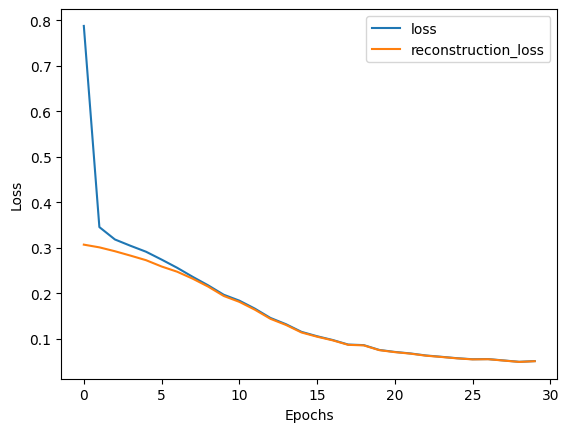

In [12]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["reconstruction_loss"], label="reconstruction_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
num_samples = 5
random_latent_points = np.random.normal(size=(num_samples, latent_dim))

In [14]:
random_latent_points.shape

(1, 4)

In [15]:
generated_data = vae.decoder.predict(random_latent_points)

1/1 [==============================] - 0s 59ms/step


In [17]:
generated_data

array([[0.10904326, 0.14646553, 0.04498366, 0.18483306, 0.4302672 ,
        0.7163099 , 0.85545665, 0.8352853 , 0.9065149 , 0.82396114,
        0.4503038 , 0.25029093, 0.2294752 , 0.12088369, 0.18400791,
        0.14501882, 0.27032205, 0.4977671 , 0.6935309 , 0.80532956,
        0.9347562 , 0.9293588 , 0.7715911 , 0.39727253, 0.47822547,
        0.        , 0.11103931, 0.11835171, 0.09554756, 0.2664052 ,
        0.3855888 , 0.66677123, 0.777081  , 0.8806374 , 0.7554293 ,
        0.817624  , 0.5784342 , 0.        , 0.2944268 , 0.12261877,
        0.20750238, 0.12625267, 0.2962797 , 0.4935878 , 0.6597497 ,
        0.96127665, 0.8246591 , 0.9277496 , 0.60900396, 0.5486557 ,
        0.29562578, 0.09328589, 0.20584083, 0.10344647, 0.10388216,
        0.4011773 , 0.66422623, 0.82649195, 0.85365117, 0.8477576 ,
        0.68457305, 0.66374856, 0.44919068, 0.31307834, 0.        ,
        0.13702324, 0.03808212, 0.24876946, 0.41356158, 0.73720205,
        0.8514857 , 0.6316732 , 0.8544044 , 0.91

<StemContainer object of 3 artists>

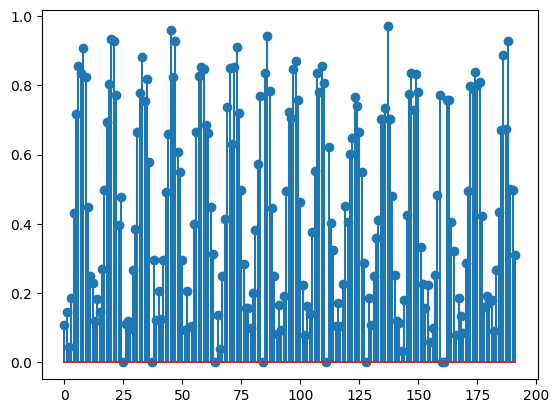

In [18]:
plt.stem(np.concatenate(generated_data))